Notebook file demonstrating how to extract camera parameters in the scene and how these camera parameters relate to the given views.

In [ ]:
import os
import numpy as np
import quaternion

import matplotlib.pyplot as plt
%matplotlib inline

import habitat
os.chdir('./..')

In [2]:
# Set up the environment for testing
config = habitat.get_config(config_paths="./configs/tasks/pointnav_rgbd.yaml")

# Can also do directly in the config file
config['SIMULATOR']['DEPTH_SENSOR']['NORMALIZE_DEPTH'] = False

# Intrinsic parameters, assuming width matches height. Requires a simple refactor otherwise
W = config['SIMULATOR']['DEPTH_SENSOR']['WIDTH']
H = config['SIMULATOR']['DEPTH_SENSOR']['HEIGHT']

assert(W == H)
hfov = float(config['SIMULATOR']['DEPTH_SENSOR']['HFOV']) * np.pi / 180.

class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()


env = SimpleRLEnv(config)
goal_radius = env.episodes[0].goals[0].radius
if goal_radius is None:
    goal_radius = config.SIMULATOR.FORWARD_STEP_SIZE

2019-06-07 13:16:20,940 initializing sim Sim-v0
2019-06-07 13:16:21,969 initializing task Nav-v0


In [3]:
# Randomly permute the rotation

def uniform_quat(original_angle):
    original_euler = quaternion.as_euler_angles(original_angle)
    euler_angles = np.array([(np.random.rand() - 0.5) * np.pi / 9. + original_euler[0],
                             (np.random.rand() - 0.5) * np.pi / 9. + original_euler[1],
                             (np.random.rand() - 0.5) * np.pi / 9. + original_euler[2]])
    quaternions = quaternion.from_euler_angles(euler_angles)
    
    
    return quaternions

In [10]:
# Generate two random, overlapping views

obs = env.reset()

depths = []
rgbs = []
cameras = []

initial_state = env._env._sim.get_agent_state(0)
init_translation = initial_state.position
init_rotation = initial_state.rotation


for i in range(0, 2):
    rotation = uniform_quat(init_rotation)
    translation = init_translation + np.random.rand(3,) * 0.5 - 0.25

    env._env._sim.set_agent_state(agent_id=0, position=translation, 
                         rotation=rotation)

    rgb = env.render(mode='rgb')
    depth = env.render(mode='depth')[:,:,0]

    depths += [depth]
    rgbs += [rgb]
    cameras += [env._env._sim.get_agent_state()]


In [11]:
### Intrinsic parameters, K

K = np.array([
    [1 / np.tan(hfov / 2.), 0., 0., 0.],
    [0., - 1 / np.tan(hfov / 2.), 0., 0.],
    [0., 0.,  -1, 0],
    [0., 0., 0, 1]])

### Now get an approximation for the true world coordinates -- see if they make sense
xs, ys = np.meshgrid(np.linspace(-1,1,W), np.linspace(-1,1,W)) 
depth = depths[0].reshape(1,W,W) 
xs = xs.reshape(1,W,W)
ys = ys.reshape(1,W,W)

### Unproject
xys = np.vstack((xs * depth , ys * depth, depth, np.ones(depth.shape)))
xys = xys.reshape(4, -1)

xyc = np.matmul(np.linalg.inv(K), xys)

### Now load in the cameras, are in the format camera --> world
# Camera 1:
quaternion_0 = cameras[0].sensor_states['depth'].rotation
translation_0 = cameras[0].sensor_states['depth'].position
rotation_0 = - quaternion.as_rotation_matrix(quaternion_0)
WRLDRT_0 = np.eye(4)
WRLDRT_0[0:3,0:3] = rotation_0
WRLDRT_0[0:3,3] = - translation_0

# Camera 2:
translation_1 = cameras[1].sensor_states['depth'].position
quaternion_1 = cameras[1].sensor_states['depth'].rotation
rotation_1 = - quaternion.as_rotation_matrix(quaternion_1)
WRLDRT_1 = np.eye(4)
WRLDRT_1[0:3,0:3] =  rotation_1
WRLDRT_1[0:3,3] = - translation_1

### Invert to get world --> camera
RT_1 = np.linalg.inv(WRLDRT_1)
RT_0 = np.linalg.inv(WRLDRT_0)

### Transformation matrix between views
RT = np.matmul(RT_1, WRLDRT_0)

### Finally transform actual points
xy_c2 = np.matmul(RT, xyc)
xy_newimg = np.matmul(K, xy_c2)

xys_newimg = xy_newimg[0:2,:] / xy_newimg[2:3,:]
xys_newimg[0].reshape(W,W)
print('Transformed points')

Transformed points


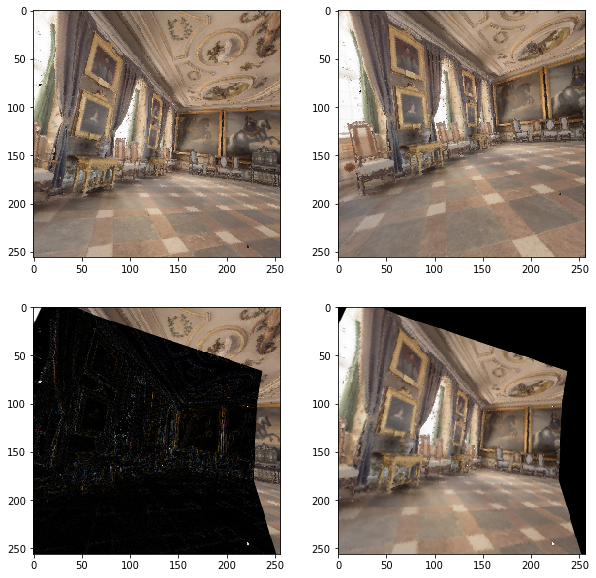

In [12]:
# And visualise this new transformation
import torch.nn.functional as F
import torch
from torchvision.transforms import ToTensor

# Create sampler
sampler = torch.Tensor(xys_newimg).view(2, W, W).permute(1,2,0).unsqueeze(0)

# Create generated image
img1_tensor = ToTensor()(rgbs[0]).unsqueeze(0)
img2_tensor = ToTensor()(rgbs[1]).unsqueeze(0)
img2_warped = F.grid_sample(img2_tensor, sampler)

# Visualise
plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax1.imshow(img1_tensor.squeeze().permute(1,2,0))
ax1 = plt.subplot(222)
ax1.imshow(img2_tensor.squeeze().permute(1,2,0))
ax1 = plt.subplot(223)
ax1.imshow(np.abs(img2_warped.squeeze().permute(1,2,0) - img1_tensor.squeeze().permute(1,2,0)))

ax1 = plt.subplot(224)
plt.imshow(img2_warped.squeeze().permute(1,2,0))